In [18]:
import os
import pandas as pd
import numpy as np
import quantstats as qs
from typing import Dict
import datetime as dt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from tqdm import tqdm
import cProfile, pstats, io

In [27]:
############ PARAMETERS #################
class Params():
    def __init__(self) -> None:
        self.period = "30mins"
        self.strike_chng = 50
        self.lot_size = 75
        self.ref_atm = 0
        self.ref_time = 0
        self.date = ""
        self.period_high = 0
        self.period_low = 0
        self.start_trading_tm = dt.time(9,22)
        self.end_ORB_tm = dt.time(10)
        self.entry_tm = dt.time(9,16)
        self.max_pos = 0
        self.net_credit = 0
        self.sid = 1
        self.enter_Trade = False
        self.re_entry = False
        self.base_straddle = 0
        self.ref_callsell_strike = 0
        self.ref_putsell_strike = 0
        self.square_off_time = dt.time(15,15)
        
        self.realised_pnl = 0
        self.unrealised_pnl = 0
        self.total_pnl = 0
        self.threshold = 0
        self.abort_strategy = 0
        
        self.spread_entry_tm = None
        self.spread_side = ""
        self.call_list = 0
        self.put_list = 0
        self.no_of_lots = 0
        self.group_stoploss = -60000
        self.trail_gp_sl = -60000
        self.gp_sl_trail_steps = 0
        self.max_m2m = 0
        self.max_calls = 0
        self.max_puts = 0 
        self.last_trade_was = None
        self.consecutive_count = 0
        self.last_call_time = None
        self.last_put_time = None
        self.last_trade_time = None
        self.thresholds_triggered = set() 

class Single_leg():
    def __init__(self):
        self.strike = 0
        self.bs = 0
        self.status = 0
        self.open_px = 0
        self.close_px = 0
        self.open_time = 0
        self.close_time = 0
        self.lots = 0
        self.m2m = 0
        self.opt_type = ""
        self.max_m2m = 0
        self.max_loss = 0
        self.sold_point = 0
        self.low = 0
        self.high = 0
        self.sell_type = ""
        self.trail_sl = 0
        self.trail_steps = 0
        self.trade_remark = ""
        self.trade_zone = ""
        self.validated = False
        self.validation_checked = False
        self.entry_RRP = 0
        self.abort_trade = 1


class Position():
    def __init__(self) -> None:
        self.open_time = None
        self.sid = 0
        self.sidm2m = 0
        self.main_leg = Single_leg()
        self.hedge_leg = Single_leg()
        
def check_orb_breakout(ohlc_df,orb_high,orb_low,end_orb_time,square_off_time):

    for i in range(len(ohlc_df) - 2):
        curr_time = ohlc_df.index[i].time()

        if curr_time > end_orb_time and curr_time < square_off_time:
            close = ohlc_df.iloc[i]['Close']
            next_close = ohlc_df.iloc[i+1]['Close']
            entry_time = ohlc_df.index[i+2].time() 

            if close > (orb_high + 2)  and next_close > (orb_high + 2):
                return True, "PUT", entry_time
            

            elif close < (orb_low - 2) and next_close < (orb_low - 2 ):
                return True, 'CALL', entry_time
            
    return False, None , None





class OHLC():
    def __init__(self):
        self.df = None
        self.timeframe = 0

    def making_ohlc(self,df,timeframe):
        self.df = df
        self.timeframe = timeframe

        
        self.df = self.df.resample(timeframe,
                                origin = "start",
                                offset = "0min").agg({"synLtp": ["first","max","min","last"]})
        self.df.columns = ["Open","High","Low","Close"]

        return self.df
    
def mark_actions_from_alerts(df, ohlc_call_5, ohlc_put_5, ohlc_call_10, ohlc_put_10):
    """
    df           : main 1-second dataframe with 'undLtp' column
    ohlc_call_5  : 5-min OHLC dataframe for CALL alerts (must have RRP, High, Low)
    ohlc_put_5   : 5-min OHLC dataframe for PUT alerts (must have RRP, High, Low)

    Returns:
        df with 'action' column marked with SELL_ITM_CALL / SELL_ITM_PUT
    """

    df["action"] = "NOTHING"

    # --- Handle CALL alerts ---
    for i, row in enumerate(ohlc_call_5.itertuples()):
        # if i == 0:
        #     continue
        prev_candle = ohlc_call_5.iloc[i - 1]
        prev_rrp = prev_candle["RRP"]
        if prev_rrp <= 0.25:   # CALL alert
            alert_idx = row.Index 
            alert_low = prev_candle["Close"]

            confirm_start = alert_idx 
            confirm_end   = alert_idx + dt.timedelta(seconds = 300)
            # print(confirm_start, "start")
            # print(confirm_end , "end")
            df_confirm = df[(df.index >= confirm_start) & (df.index <= confirm_end)]
            
            if not df_confirm.empty:
                confirm_close = df_confirm["synLtp"].iloc[-1]
                confirm_open = df_confirm["synLtp"].iloc[0]
                if confirm_close < confirm_open :
                    # mark entry at next tick
                    entry_time = confirm_end + dt.timedelta(seconds=15)
                    if entry_time in df.index:
                        df.at[entry_time, "action"] = "SELL_ITM_CALL"
                    else:
                        later_idx = df[df.index > entry_time].index.min()
                        if pd.notna(later_idx):
                            df.at[later_idx, "action"] = "SELL_ITM_CALL"

    # --- Handle PUT alerts ---
    for i, row in enumerate(ohlc_put_5.itertuples()):
        # if i == 0:
        #     continue
        prev_candle = ohlc_put_5.iloc[i - 1]
        prev_rrp = prev_candle["RRP"]
        if prev_rrp >= 0.75:  # PUT alert
            alert_idx = row.Index
            alert_high = prev_candle["Close"]

            confirm_start = alert_idx 
            confirm_end   = alert_idx + dt.timedelta(seconds = 300)
            # print(confirm_start, "start")
            # print(confirm_end , "end")

            df_confirm = df[(df.index >= confirm_start) & (df.index <= confirm_end)]
            # print(df_confirm.to_markdown())
            if not df_confirm.empty:
                confirm_close = df_confirm["synLtp"].iloc[-1]
                confirm_open = df_confirm["synLtp"].iloc[0]
                if confirm_close > confirm_open:
                    # print(confirm_close )
                    # print(confirm_open )
                    entry_time = confirm_end + dt.timedelta(seconds=15)
                    # print(entry_time)
                    if entry_time in df.index:
                        df.at[entry_time, "action"] = "SELL_ITM_PUT"
                    else:
                        later_idx = df[df.index > entry_time].index.min()
                        if pd.notna(later_idx):
                            df.at[later_idx, "action"] = "SELL_ITM_PUT"
    

    
    return df

def can_take_trade(curr_time, opt_type, last_time, min_gap=5):
    if opt_type == "CE":

        if last_time is None:
            return True
        return (curr_time - last_time).total_seconds() >= min_gap * 60
    elif opt_type == "PE":
        if last_time is None:
            return True
        return (curr_time - last_time).total_seconds() >= min_gap * 60
    return False




In [20]:
import numpy as np
import pandas as pd

def calculate_values_vec(df):
    # ensure synth numeric
    if not pd.api.types.is_numeric_dtype(df["synth"].dtype):
        df["synth"] = pd.to_numeric(df["synth"], errors="coerce")

    n = len(df)
    row_idx = np.arange(n, dtype=int)
    synth_arr = df["synth"].to_numpy(dtype=float)

    # Build initial CE/PE column names based on synth (per-row)
    synth_str = df["synth"].astype(pd.StringDtype()).astype(str)
    ce_cols = np.char.add("CE_", np.char.add(synth_str.to_numpy(), "_0_W_ltp"))
    pe_cols = np.char.add("PE_", np.char.add(synth_str.to_numpy(), "_0_W_ltp"))

    # Determine which of these columns actually exist in df
    existing_cols = set(df.columns)
    needed_initial = sorted({c for c in np.concatenate([ce_cols, pe_cols]) if c in existing_cols})

    # Build a small numeric-only view containing only needed_initial columns
    sub_df = df.loc[:, needed_initial].copy() if needed_initial else pd.DataFrame(index=df.index)
    # Coerce to numeric only these columns
    for col in sub_df.columns:
        if not pd.api.types.is_numeric_dtype(sub_df[col].dtype):
            sub_df[col] = pd.to_numeric(sub_df[col], errors="coerce")

    # Map column name -> position within sub_df
    sub_cols = sub_df.columns.to_list()
    sub_pos = {c: i for i, c in enumerate(sub_cols)}
    sub_vals = sub_df.to_numpy(dtype=float) if len(sub_cols) > 0 else np.empty((n, 0), dtype=float)

    # Build integer index arrays for CE/PE initial
    ce_idx = np.array([sub_pos.get(c, -1) for c in ce_cols], dtype=int)
    pe_idx = np.array([sub_pos.get(c, -1) for c in pe_cols], dtype=int)

    # Extract ce_values and pe_values (NaN if missing)
    ce_values = np.full(n, np.nan, dtype=float)
    pe_values = np.full(n, np.nan, dtype=float)
    valid_ce = ce_idx >= 0
    valid_pe = pe_idx >= 0
    if valid_ce.any():
        ce_values[valid_ce] = sub_vals[row_idx[valid_ce], ce_idx[valid_ce]]
    if valid_pe.any():
        pe_values[valid_pe] = sub_vals[row_idx[valid_pe], pe_idx[valid_pe]]

    # Compute atm strike (rounded to nearest 50)
    with np.errstate(invalid="ignore"):
        atm_raw = (synth_arr + ce_values - pe_values) / 50.0
        atm_rounded = np.rint(atm_raw) * 50.0  # float array with NaN where not computable

    # Prepare atm_strike integer output (use NaN for invalids)
    atm_valid = ~np.isnan(atm_rounded)
    atm_strike_out = np.full(n, np.nan, dtype=float)
    if atm_valid.any():
        atm_strike_out[atm_valid] = atm_rounded[atm_valid].astype(int).astype(float)

    # --- Second pass: need CE_atm and PE_atm columns to build straddlePx ---
    # Build the atm CE/PE column names for rows where we have atm_strike
    atm_strs = np.where(atm_valid, atm_rounded.astype(int).astype(str), "")
    atm_ce_cols = np.char.add("CE_", np.char.add(atm_strs, "_0_W_ltp"))
    atm_pe_cols = np.char.add("PE_", np.char.add(atm_strs, "_0_W_ltp"))

    needed_atm = sorted({c for c in np.concatenate([atm_ce_cols, atm_pe_cols]) if c in existing_cols})

    # Combine initial needed and atm-needed, but only if they exist in df
    all_needed = sorted(set(needed_initial) | set(needed_atm))

    # Build final sub_df with all needed columns (avoid converting the whole df)
    if len(all_needed) > 0:
        final_sub_df = df.loc[:, all_needed].copy()
        for col in final_sub_df.columns:
            if not pd.api.types.is_numeric_dtype(final_sub_df[col].dtype):
                final_sub_df[col] = pd.to_numeric(final_sub_df[col], errors="coerce")
        final_vals = final_sub_df.to_numpy(dtype=float)
        final_pos = {c: i for i, c in enumerate(final_sub_df.columns.to_list())}
    else:
        final_vals = np.empty((n, 0), dtype=float)
        final_pos = {}

    # Build indices into final_vals for atm CE/PE
    atm_ce_idx = np.array([final_pos.get(c, -1) for c in atm_ce_cols], dtype=int)
    atm_pe_idx = np.array([final_pos.get(c, -1) for c in atm_pe_cols], dtype=int)

    # Compute straddlePx where both atm CE and PE exist
    straddle_px = np.full(n, np.nan, dtype=float)
    valid_atm_cols = (atm_ce_idx >= 0) & (atm_pe_idx >= 0)
    if valid_atm_cols.any():
        straddle_px[valid_atm_cols] = (
            final_vals[row_idx[valid_atm_cols], atm_ce_idx[valid_atm_cols]]
            + final_vals[row_idx[valid_atm_cols], atm_pe_idx[valid_atm_cols]]
        )

    # Return DataFrame with same index and column names matching your usage
    return pd.DataFrame({"atm_strike": atm_strike_out, "Straddle_Px": straddle_px}, index=df.index)

import numpy as np
import pandas as pd

def get_synthetic_vec(df):
    """
    Vectorized replacement for per-row synthetic calculation.
    Returns a numpy array (float or int) that you can assign to df['synLtp'].
    Works even if many non-numeric columns exist in df.
    """
    n = len(df)
    if n == 0:
        return np.array([], dtype=float)

    # ensure synth numeric
    synth_arr = pd.to_numeric(df["synth"], errors="coerce").to_numpy(dtype=float)

    # build required per-row column names
    synth_str = df["synth"].astype(str).to_numpy()
    ce_cols = np.char.add("CE_", np.char.add(synth_str, "_0_W_ltp"))
    pe_cols = np.char.add("PE_", np.char_add(synth_str, "_0_W_ltp") if False else np.char.add(synth_str, "_0_W_ltp"))
    # (above line uses same pattern for both; left readable)

    # get set of columns that actually exist in df
    existing = set(df.columns)

    # collect unique needed column names (that exist) to avoid coercing whole df
    needed = sorted({c for c in np.concatenate([ce_cols, pe_cols]) if c in existing})

    if needed:
        sub = df.loc[:, needed].copy()
        # coerce only these columns
        for col in sub.columns:
            if not pd.api.types.is_numeric_dtype(sub[col].dtype):
                sub[col] = pd.to_numeric(sub[col], errors="coerce")
        sub_vals = sub.to_numpy(dtype=float)
        sub_pos = {c: i for i, c in enumerate(sub.columns)}
    else:
        sub_vals = np.empty((n, 0), dtype=float)
        sub_pos = {}

    row_idx = np.arange(n, dtype=int)

    # build indices into sub_vals for ce/pe columns (use -1 for missing)
    ce_idx = np.array([sub_pos.get(c, -1) for c in ce_cols], dtype=int)
    pe_idx = np.array([sub_pos.get(c, -1) for c in pe_cols], dtype=int)

    # extract values (NaN where missing)
    ce_values = np.full(n, np.nan, dtype=float)
    pe_values = np.full(n, np.nan, dtype=float)
    valid_ce = ce_idx >= 0
    valid_pe = pe_idx >= 0
    if valid_ce.any():
        ce_values[valid_ce] = sub_vals[row_idx[valid_ce], ce_idx[valid_ce]]
    if valid_pe.any():
        pe_values[valid_pe] = sub_vals[row_idx[valid_pe], pe_idx[valid_pe]]

    # compute synthetic: round to nearest 50 as in your code
    with np.errstate(invalid="ignore"):
        atm_raw = (synth_arr + ce_values - pe_values) 
        syn = atm_raw

    # If you prefer integer dtype for whole column (and no NaNs exist), convert:
    # but keep float to preserve NaN if any
    return syn


In [21]:
expiries = [
    '2024-01-04', '2024-01-11', '2024-01-18', '2024-01-25',
    '2024-02-01', '2024-02-08', '2024-02-15', '2024-02-22', '2024-02-29',
    '2024-03-07', '2024-03-14', '2024-03-21', '2024-03-28',
    '2024-04-04', '2024-04-10', '2024-04-18', '2024-04-25',
    '2024-05-02', '2024-05-09', '2024-05-16', '2024-05-23', '2024-05-30',
    '2024-06-06', '2024-06-13', '2024-06-20', '2024-06-27',
    '2024-07-04', '2024-07-11', '2024-07-18', '2024-07-25',
    '2024-08-01', '2024-08-08', '2024-08-14', '2024-08-22', '2024-08-29',
    '2024-09-05', '2024-09-12', '2024-09-19', '2024-09-26',
    '2024-10-03', '2024-10-10', '2024-10-17', '2024-10-24', '2024-10-31',
    '2024-11-07', '2024-11-14', '2024-11-21', '2024-11-28',
    '2024-12-05', '2024-12-12', '2024-12-19', '2024-12-26',
    '2025-01-02', '2025-01-09', '2025-01-16', '2025-01-23', '2025-01-30',
    '2025-02-06', '2025-02-13', '2025-02-20', '2025-02-27',
    '2025-03-06', '2025-03-13', '2025-03-20', '2025-03-27',
    '2025-04-03', '2025-04-09', '2025-04-17', '2025-04-24',
    '2025-04-30', '2025-05-08', '2025-05-15', '2025-05-22', '2025-05-29',
    '2025-06-05', '2025-06-12', '2025-06-19', '2025-06-26',
    '2025-07-03', '2025-07-10', '2025-07-17', '2025-07-24', '2025-07-31',
    '2025-08-07', '2025-08-14', '2025-08-21', '2025-08-28',
    '2025-09-04', '2025-09-11', '2025-09-18', '2025-09-25',
    '2025-10-02', '2025-10-09', '2025-10-16', '2025-10-23', '2025-10-30',
    '2025-11-06', '2025-11-13', '2025-11-20', '2025-11-27',
    '2025-12-04', '2025-12-11', '2025-12-18', '2025-12-24'
]

expiry_set = set(expiries)

In [22]:
instrument = "NIFTY"
years = [2024,2025]
months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
# months = ["FEB"]
all_positions = []
pos_m2m_list = []
for year in years:
    for mnth in months:
        path = r"D:\USER_DATA\Desktop\Data For testing\{}\{}\_1s\{}".format(year,mnth,instrument)
        dirlist = os.listdir(path)
        
        for files in dirlist:
            file = files.replace(".feather","")

            if file in ["2025-04-07", "2025-04-08","2024-06-03", "2024-06-04", "2024-05-31"]:
                continue
            elif file :
                print("date: " , file)
                model_params = Params()
                try:
                    path = r"D:\USER_DATA\Desktop\Data For testing\{}\{}\_1s\{}\{}.feather".format(year,mnth,instrument,file)
                    df = pd.read_feather(path)
                    positions_map:Dict[int,Position] = {}
                    try:
                        df["timestamp"] = df["Datetime"]
                    except:
                        pass
                    df["timestamp"] = pd.to_datetime(df.timestamp, format="%Y-%m-%d %H:%M:%S")
                    df = df.set_index("timestamp")
                    df = df.ffill()
                    df = df.bfill()
                    try:
                        df["futpx"] = df["futLtp"]
                    except KeyError:
                        try:
                            df["futpx"] = df["synLtp"]
                        except KeyError:
                            df["futpx"] = df["undLtp"]
                    df["synth"] = (round(df['futpx']/50)*50).astype(int)
                    df[["atm_strike", "Straddle_Px"]] = calculate_values_vec(df)
                    df["synLtp"] = get_synthetic_vec(df)
                    df['atm_strike'] = df['atm_strike'].astype(int)
                    df = df.ffill()
                    

                    ohlc = OHLC()
                    ohlc_call_3 = OHLC().making_ohlc(df, "3min")
                    ohlc_put_3  = OHLC().making_ohlc(df, "3min")
                    ohlc_call_10 = OHLC().making_ohlc(df, "10min")
                    ohlc_put_10  = OHLC().making_ohlc(df, "10min")

                    ohlc_call_3["RRP"] = (ohlc_call_3["Close"] - ohlc_call_3["Low"]) / (ohlc_call_3["High"] - ohlc_call_3["Low"])
                    ohlc_call_3["action"] = "NOTHING"

                    # --- Add RRP & init action for PUT ---
                    ohlc_put_3["RRP"] = (ohlc_put_3["Close"] - ohlc_put_3["Low"]) / (ohlc_put_3["High"] - ohlc_put_3["Low"])
                    ohlc_put_3["action"] = "NOTHING"

                    ohlc_call_10["RRP"] = (ohlc_call_10["Close"] - ohlc_call_10["Low"]) / (ohlc_call_10["High"] - ohlc_call_10["Low"])
                    ohlc_call_10["action"] = "NOTHING"

                    # --- Add RRP & init action for PUT ---
                    ohlc_put_10["RRP"] = (ohlc_put_10["Close"] - ohlc_put_10["Low"]) / (ohlc_put_10["High"] - ohlc_put_10["Low"])
                    ohlc_put_10["action"] = "NOTHING"
                    # --- Now call the function ---
                    df = mark_actions_from_alerts(df, ohlc_call_3, ohlc_put_3,ohlc_call_10,ohlc_put_10 ) 
                    

                    for idx in (df.itertuples()):
                        curr_time = idx.Index.time()
                        curr_idx = idx.Index

                        undltp = idx.synLtp
                        if curr_time == model_params.entry_tm:
                            model_params.base_straddle = idx.Straddle_Px
                            print("base straddle", model_params.base_straddle)

                        if model_params.start_trading_tm < curr_time and model_params.abort_strategy == 0 :
                            if model_params.no_of_lots < 20 and curr_time <= dt.time(15) :
                                    if idx.action == "SELL_ITM_CALL" and can_take_trade(curr_idx,"PE",model_params.last_put_time):
                                        sid = model_params.sid
                                        positions_map[sid] = Position()
                                        pos = positions_map[sid]
                                        pos.sid = sid
                                        if model_params.base_straddle <= 150: 
                                            atm_strike = idx.atm_strike - 100
                                            
                                        elif model_params.base_straddle >= 500:
                                            atm_strike = idx.atm_strike + 100
                                            
                                        else:
                                            atm_strike = idx.atm_strike - 50
                                        pos.main_leg.opt_type = "CE"
                                        pos.main_leg.strike = atm_strike 
                                        pos.main_leg.open_px = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                                        pos.main_leg.status = 1
                                        pos.main_leg.low = pos.main_leg.open_px
                                        pos.main_leg.sold_point = undltp
                                        if file in expiries :
                                            pos.main_leg.trail_sl = pos.main_leg.open_px * 1.8
                                        else:
                                            pos.main_leg.trail_sl = pos.main_leg.open_px * 1.8

                                       
                                        pos.main_leg.bs = -1
                                        pos.main_leg.lots = 1
                                        pos.main_leg.open_time = curr_idx
                                        model_params.last_call_time = curr_idx
                                        model_params.sid += 1
                                        model_params.no_of_lots += 1
                                        # print(model_params.no_of_lots)
                                        model_params.call_list += 1

                                    if idx.action == "SELL_ITM_PUT" and can_take_trade(curr_idx,"CE",model_params.last_call_time):
                                        sid = model_params.sid
                                        positions_map[sid] = Position()
                                        pos = positions_map[sid]
                                        pos.sid = sid
                                        atm_strike = idx.atm_strike 
                                        pos.main_leg.opt_type = "PE"
                                        if model_params.base_straddle <= 150: 
                                            atm_strike = idx.atm_strike + 100

                                        elif model_params.base_straddle >= 500:
                                            atm_strike = idx.atm_strike - 100
                                            
                                        else:
                                            atm_strike = idx.atm_strike  + 50
                                        pos.main_leg.strike = atm_strike 
                                        pos.main_leg.open_px = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                                        pos.main_leg.status = 1
                                        pos.main_leg.low = pos.main_leg.open_px
                                        pos.main_leg.sold_point = undltp
                                        if file in expiries :
                                            pos.main_leg.trail_sl = pos.main_leg.open_px * 1.8
                                        else:
                                            pos.main_leg.trail_sl = pos.main_leg.open_px * 1.8

                                        pos.main_leg.bs = -1
                                        pos.main_leg.lots = 1
                                        pos.main_leg.open_time = curr_idx
                                        model_params.last_put_time = curr_idx
                                        model_params.sid += 1
                                        model_params.no_of_lots += 1
                                        # print(model_params.no_of_lots)
                                        model_params.put_list += 1

                            


                            model_params.unrealised_pnl = 0
                            model_params.realised_pnl = 0
                            model_params.total_pnl = 0
                            
                            for sid, pos in positions_map.items():
                                if pos.main_leg.status == 1:
                                    ltp = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                                    pos.main_leg.m2m = (pos.main_leg.open_px - ltp) * model_params.lot_size

                                    model_params.unrealised_pnl += pos.main_leg.m2m

                                else:
                                    pos.main_leg.m2m = (pos.main_leg.open_px - pos.main_leg.close_px) * model_params.lot_size
                                    model_params.realised_pnl += pos.main_leg.m2m

                            model_params.total_pnl = model_params.unrealised_pnl + model_params.realised_pnl
                            

                            if model_params.max_m2m == 0:
                                model_params.max_m2m = model_params.total_pnl
                            if model_params.total_pnl > model_params.max_m2m:
                                model_params.max_m2m = model_params.total_pnl


                            for sid , pos in positions_map.items():
                                if pos.main_leg.status == 1:
                                    ltp = getattr(idx,f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                                    if ltp < pos.main_leg.low:
                                        pos.main_leg.low = ltp
                                    if ltp > pos.main_leg.high:
                                        pos.main_leg.high = ltp
                                    # favorable_move = pos.main_leg.open_px - ltp
                                    # if favorable_move > 0:
                                    #     steps = int(favorable_move // 5)
                                    #     if steps > pos.main_leg.trail_steps:
                                    #         diff = steps - pos.main_leg.trail_steps
                                    #         # if ltp <= (pos.main_leg.open_px * 0.50): 
                                    #         pos.main_leg.trail_sl -= diff * 2.5
                                    #         # else:
                                    #         #     pos.main_leg.trail_sl -= diff * 1.5
                                    #         pos.main_leg.trail_steps = steps
                                    

                                    if ltp >= pos.main_leg.low * 1.8:
                                        pos.main_leg.status = 0
                                        pos.main_leg.close_px = ltp
                                        pos.main_leg.close_time = curr_idx
                                        pos.main_leg.trade_remark = "Stoploss"
                                        model_params.no_of_lots -= 1
                                        if pos.main_leg.opt_type == "CE":
                                            model_params.call_list -= 1
                                        else:
                                            model_params.put_list -= 1
                                    if file in expiry_set:
                                        if ltp <= (pos.main_leg.open_px * 0.15):
                                            pos.main_leg.status = 0
                                            pos.main_leg.close_px = ltp
                                            pos.main_leg.close_time = curr_idx
                                            pos.main_leg.trade_remark = "Profit_booking"
                                            model_params.no_of_lots -= 1
                                        if pos.main_leg.opt_type == "CE":
                                            model_params.call_list -= 1
                                        else:
                                            model_params.put_list -= 1
                                    else:
                                        if ltp <= (pos.main_leg.open_px * 0.40):
                                            pos.main_leg.status = 0
                                            pos.main_leg.close_px = ltp
                                            pos.main_leg.close_time = curr_idx
                                            pos.main_leg.trade_remark = "Profit_booking"
                                            model_params.no_of_lots -= 1
                                        
                                    steps_ = int(model_params.max_m2m // 10000) if model_params.max_m2m > 0 else 0
                                    if steps_ != model_params.gp_sl_trail_steps:
                                        model_params.trail_gp_sl = model_params.group_stoploss + (steps_ * 5000)
                                        # print(model_params.trail_gp_sl)
                                        # ensure group_sl does not become positive
                                        model_params.trail_gp_sl = min(model_params.trail_gp_sl, 0)
                                        model_params.gp_sl_trail_steps = steps_

                                    if model_params.total_pnl <= model_params.trail_gp_sl or model_params.total_pnl >= (abs(model_params.group_stoploss) * 1.5):
                                        if pos.main_leg.status == 1:
                                                pos.main_leg.status = 0
                                                pos.main_leg.close_px = ltp
                                                pos.main_leg.close_time = curr_idx
                                                pos.main_leg.trade_remark = "Groupstoploss"
                                                model_params.abort_strategy = 1
                                    if curr_time >= model_params.square_off_time:
                                        if pos.main_leg.status == 1:
                                            pos.main_leg.status = 0
                                            pos.main_leg.close_px = ltp
                                            pos.main_leg.close_time = curr_idx
                                            pos.main_leg.trade_remark = "Timeexit"
                                    
                                         
                except Exception as e:
                    print(f"Missing data for {file}, skipping this day")
                    print("error caught", e)
                    
                    continue
                print("PNL: ",model_params.total_pnl)
                print("max m2m : " , model_params.max_m2m)
                all_positions.append(positions_map)


date:  2024-01-01
base straddle 245.8
PNL:  -34001.25
max m2m :  21967.5
date:  2024-01-02
base straddle 196.2
PNL:  3727.499999999998
max m2m :  4923.75
date:  2024-01-03
base straddle 165.3
PNL:  382.49999999999727
max m2m :  2962.5
date:  2024-01-04-greek.parquet
Missing data for 2024-01-04-greek.parquet, skipping this day
error caught [Errno 2] No such file or directory: 'D:\\USER_DATA\\Desktop\\Data For testing\\2024\\JAN\\_1s\\NIFTY\\2024-01-04-greek.parquet.feather'
date:  2024-01-04
base straddle 86.3
PNL:  8006.249999999999
max m2m :  9397.5
date:  2024-01-05
base straddle 237.4
PNL:  750.0000000000073
max m2m :  3382.500000000001
date:  2024-01-08
base straddle 206.1
PNL:  18315.00000000001
max m2m :  21566.250000000007
date:  2024-01-09
base straddle 171.8
PNL:  -11478.75
max m2m :  405.00000000000045
date:  2024-01-10
base straddle 160.14999999999998
PNL:  -17831.25
max m2m :  2141.250000000001
date:  2024-01-11-greek.parquet
Missing data for 2024-01-11-greek.parquet, skipp

KeyboardInterrupt: 

In [36]:
import os
import pandas as pd
import datetime as dt
from typing import Dict

instrument = "NIFTY"
years = [2024, 2025]
months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
all_positions = []

for year in years:
    for mnth in months:
        path = r"D:\USER_DATA\Desktop\Data For testing\{}\{}\_1s\{}".format(year, mnth, instrument)
        dirlist = os.listdir(path)

        for files in dirlist:
            file = files.replace(".feather", "")

            if file in ["2025-04-07", "2025-04-08", "2024-06-03", "2024-06-04", "2024-05-31"]:
                continue
            elif file :
                print("date:", file)
                model_params = Params()
                try:
                    path = r"D:\USER_DATA\Desktop\Data For testing\{}\{}\_1s\{}\{}.feather".format(year, mnth, instrument, file)
                    df = pd.read_feather(path)
                    positions_map: Dict[int, Position] = {}
                    try:
                        df["timestamp"] = df["Datetime"]
                    except:
                        pass
                    df["timestamp"] = pd.to_datetime(df.timestamp, format="%Y-%m-%d %H:%M:%S")
                    df = df.set_index("timestamp")
                    df = df.ffill()
                    df = df.bfill()
                    try:
                        df["futpx"] = df["futLtp"]
                    except KeyError:
                        try:
                            df["futpx"] = df["synLtp"]
                        except KeyError:
                            df["futpx"] = df["undLtp"]
                    df["synth"] = (round(df['futpx'] / 50) * 50).astype(int)
                    df[["atm_strike", "Straddle_Px"]] = calculate_values_vec(df)
                    df["synLtp"] = get_synthetic_vec(df)
                    df['atm_strike'] = df['atm_strike'].astype(int)
                    df = df.ffill()

                    ohlc_call_3 = OHLC().making_ohlc(df, "3min")
                    ohlc_put_3 = OHLC().making_ohlc(df, "3min")
                    ohlc_call_10 = OHLC().making_ohlc(df, "10min")
                    ohlc_put_10 = OHLC().making_ohlc(df, "10min")

                    ohlc_call_3["RRP"] = (ohlc_call_3["Close"] - ohlc_call_3["Low"]) / (ohlc_call_3["High"] - ohlc_call_3["Low"])
                    ohlc_call_3["action"] = "NOTHING"
                    ohlc_put_3["RRP"] = (ohlc_put_3["Close"] - ohlc_put_3["Low"]) / (ohlc_put_3["High"] - ohlc_put_3["Low"])
                    ohlc_put_3["action"] = "NOTHING"
                    ohlc_call_10["RRP"] = (ohlc_call_10["Close"] - ohlc_call_10["Low"]) / (ohlc_call_10["High"] - ohlc_call_10["Low"])
                    ohlc_call_10["action"] = "NOTHING"
                    ohlc_put_10["RRP"] = (ohlc_put_10["Close"] - ohlc_put_10["Low"]) / (ohlc_put_10["High"] - ohlc_put_10["Low"])
                    ohlc_put_10["action"] = "NOTHING"

                    df = mark_actions_from_alerts(df, ohlc_call_3, ohlc_put_3, ohlc_call_10, ohlc_put_10)

                    for idx in df.itertuples():
                        curr_time = idx.Index.time()
                        curr_idx = idx.Index
                        undltp = idx.synLtp

                        if curr_time == model_params.entry_tm:
                            model_params.base_straddle = idx.Straddle_Px
                            print("base straddle", model_params.base_straddle)

                        if model_params.start_trading_tm < curr_time and model_params.abort_strategy == 0:
                            if model_params.no_of_lots < 20 and curr_time <= dt.time(15):
                                if idx.action == "SELL_ITM_CALL" and can_take_trade(curr_idx, "PE", model_params.last_put_time):
                                    sid = model_params.sid
                                    positions_map[sid] = Position()
                                    pos = positions_map[sid]
                                    pos.sid = sid
                                    if model_params.base_straddle <= 150:
                                        atm_strike = idx.atm_strike - 100
                                    elif model_params.base_straddle >= 500:
                                        atm_strike = idx.atm_strike + 50
                                    else:
                                        atm_strike = idx.atm_strike - 50
                                    pos.main_leg.opt_type = "CE"
                                    pos.main_leg.strike = atm_strike
                                    pos.main_leg.open_px = getattr(idx, f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                                    pos.main_leg.status = 1
                                    pos.main_leg.low = pos.main_leg.open_px
                                    pos.main_leg.sold_point = undltp
                                    pos.main_leg.trail_sl = pos.main_leg.open_px * 1.8
                                    pos.main_leg.bs = -1
                                    pos.main_leg.lots = 1
                                    pos.main_leg.open_time = curr_idx
                                    model_params.last_call_time = curr_idx
                                    model_params.sid += 1
                                    model_params.no_of_lots += 1
                                    model_params.call_list += 1

                                if idx.action == "SELL_ITM_PUT" and can_take_trade(curr_idx, "CE", model_params.last_call_time):
                                    sid = model_params.sid
                                    positions_map[sid] = Position()
                                    pos = positions_map[sid]
                                    pos.sid = sid
                                    atm_strike = idx.atm_strike
                                    pos.main_leg.opt_type = "PE"
                                    if model_params.base_straddle <= 150:
                                        atm_strike = idx.atm_strike + 100
                                    elif model_params.base_straddle >= 500:
                                        atm_strike = idx.atm_strike - 50
                                    else:
                                        atm_strike = idx.atm_strike + 50
                                    pos.main_leg.strike = atm_strike
                                    pos.main_leg.open_px = getattr(idx, f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                                    pos.main_leg.status = 1
                                    pos.main_leg.low = pos.main_leg.open_px
                                    pos.main_leg.sold_point = undltp
                                    pos.main_leg.trail_sl = pos.main_leg.open_px * 1.8
                                    pos.main_leg.bs = -1
                                    pos.main_leg.lots = 1
                                    pos.main_leg.open_time = curr_idx
                                    model_params.last_put_time = curr_idx
                                    model_params.sid += 1
                                    model_params.no_of_lots += 1
                                    model_params.put_list += 1

                            model_params.unrealised_pnl = 0
                            model_params.realised_pnl = 0
                            model_params.total_pnl = 0
                            for sid, pos in positions_map.items():
                                if pos.main_leg.status == 1:
                                    ltp = getattr(idx, f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                                    pos.main_leg.m2m = (pos.main_leg.open_px - ltp) * model_params.lot_size
                                    model_params.unrealised_pnl += pos.main_leg.m2m
                                else:
                                    pos.main_leg.m2m = (pos.main_leg.open_px - pos.main_leg.close_px) * model_params.lot_size
                                    model_params.realised_pnl += pos.main_leg.m2m

                            model_params.total_pnl = model_params.unrealised_pnl + model_params.realised_pnl

                            # if not hasattr(model_params, "thresholds_triggered"):
                            #     model_params.thresholds_triggered = set()
                            # CAPITAL_FIXED = 4_000_000
                            # thresholds = [(0.0025, "T25"), (0.005, "T50"), (0.0075, "T75")]
                            # open_positions = [(sid, pos) for sid, pos in positions_map.items() if pos.main_leg.status == 1]
                            # if open_positions:
                            #     pos_m2m_list = []
                            #     for sid, pos in open_positions:
                            #         m = getattr(pos.main_leg, "m2m", None)
                            #         if m is None:
                            #             try:
                            #                 ltp = getattr(idx, f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                            #                 m = (pos.main_leg.open_px - ltp) * model_params.lot_size
                            #             except Exception:
                            #                 m = -9e18
                            #         pos_m2m_list.append((sid, pos, m))
                            #     pos_m2m_list.sort(key=lambda x: x[2], reverse=True)
                            #     for pct, label in thresholds:
                            #         if label in model_params.thresholds_triggered:
                            #             continue
                            #         threshold_value = CAPITAL_FIXED * pct
                            #         if model_params.total_pnl >= threshold_value and pos_m2m_list:
                            #             n_to_close = 1
                            #             closed = 5
                            #             for sid, pos, m2m in list(pos_m2m_list):
                            #                 if closed >= n_to_close:
                            #                     break
                            #                 if pos.main_leg.status == 1:
                            #                     try:
                            #                         ltp = getattr(idx, f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                            #                     except Exception:
                            #                         continue
                            #                     pos.main_leg.status = 0
                            #                     pos.main_leg.close_px = ltp
                            #                     pos.main_leg.close_time = curr_idx
                            #                     pos.main_leg.trade_remark = f"Threshold_{int(pct*10000)/100:.2f}%_take"
                            #                     # model_params.no_of_lots = max(0, model_params.no_of_lots - pos.main_leg.lots)
                            #                     if pos.main_leg.opt_type == "CE":
                            #                         model_params.call_list = max(0, model_params.call_list - pos.main_leg.lots)
                            #                     else:
                            #                         model_params.put_list = max(0, model_params.put_list - pos.main_leg.lots)
                            #                     closed += 1
                            #             model_params.thresholds_triggered.add(label)
                            #             model_params.unrealised_pnl = 0
                            #             model_params.realised_pnl = 0
                                        # for s, p in positions_map.items():
                                        #     if p.main_leg.status == 1:
                                        #         try:
                                        #             l = getattr(idx, f"{p.main_leg.opt_type}_{p.main_leg.strike}_0_W_ltp")
                                        #             p.main_leg.m2m = (p.main_leg.open_px - l) * model_params.lot_size
                                        #             model_params.unrealised_pnl += p.main_leg.m2m
                                        #         except Exception:
                                        #             pass
                                        #     else:
                                        #         p.main_leg.m2m = (p.main_leg.open_px - p.main_leg.close_px) * model_params.lot_size
                                        #         model_params.realised_pnl += p.main_leg.m2m
                                        # model_params.total_pnl = model_params.unrealised_pnl + model_params.realised_pnl
                                        # pos_m2m_list = [(s, p, getattr(p.main_leg, "m2m", -9e18)) for s, p, _ in pos_m2m_list if p.main_leg.status == 1]

                            if model_params.max_m2m == 0:
                                model_params.max_m2m = model_params.total_pnl
                            if model_params.total_pnl > model_params.max_m2m:
                                model_params.max_m2m = model_params.total_pnl

                            for sid, pos in positions_map.items():
                                if pos.main_leg.status == 1:
                                    ltp = getattr(idx, f"{pos.main_leg.opt_type}_{pos.main_leg.strike}_0_W_ltp")
                                    if ltp < pos.main_leg.low:
                                        pos.main_leg.low = ltp
                                    if ltp > pos.main_leg.high:
                                        pos.main_leg.high = ltp
                                    if ltp >= pos.main_leg.low * 1.8:
                                        pos.main_leg.status = 0
                                        pos.main_leg.close_px = ltp
                                        pos.main_leg.close_time = curr_idx
                                        pos.main_leg.trade_remark = "Stoploss"
                                        model_params.no_of_lots -= 1
                                        if pos.main_leg.opt_type == "CE":
                                            model_params.call_list -= 1
                                        else:
                                            model_params.put_list -= 1
                                    if file in expiry_set:
                                        if ltp <= (pos.main_leg.open_px * 0.15):
                                            pos.main_leg.status = 0
                                            pos.main_leg.close_px = ltp
                                            pos.main_leg.close_time = curr_idx
                                            pos.main_leg.trade_remark = "Profit_booking"
                                            model_params.no_of_lots -= 1
                                        if pos.main_leg.opt_type == "CE":
                                            model_params.call_list -= 1
                                        else:
                                            model_params.put_list -= 1
                                    else:
                                        if ltp <= (pos.main_leg.open_px * 0.50):
                                            pos.main_leg.status = 0
                                            pos.main_leg.close_px = ltp
                                            pos.main_leg.close_time = curr_idx
                                            pos.main_leg.trade_remark = "Profit_booking"
                                            model_params.no_of_lots -= 1
                                    if model_params.total_pnl <= model_params.trail_gp_sl or model_params.total_pnl >= (abs(model_params.group_stoploss) * 1.5):
                                        if pos.main_leg.status == 1:
                                            pos.main_leg.status = 0
                                            pos.main_leg.close_px = ltp
                                            pos.main_leg.close_time = curr_idx
                                            pos.main_leg.trade_remark = "Groupstoploss"
                                            model_params.abort_strategy = 1
                                    if curr_time >= model_params.square_off_time:
                                        if pos.main_leg.status == 1:
                                            pos.main_leg.status = 0
                                            pos.main_leg.close_px = ltp
                                            pos.main_leg.close_time = curr_idx
                                            pos.main_leg.trade_remark = "Timeexit"
                except Exception as e:
                    print(f"Missing data for {file}, skipping this day")
                    print("error caught", e)
                    continue
                print("PNL:", model_params.total_pnl)
                print("max m2m:", model_params.max_m2m)
                all_positions.append(positions_map)


date: 2024-01-01
base straddle 245.8
PNL: -14268.750000000004
max m2m: 16725.0
date: 2024-01-02
base straddle 196.2
PNL: 6239.999999999997
max m2m: 8444.999999999996
date: 2024-01-03
base straddle 165.3
PNL: -5287.5
max m2m: 2951.250000000001
date: 2024-01-04-greek.parquet
Missing data for 2024-01-04-greek.parquet, skipping this day
error caught [Errno 2] No such file or directory: 'D:\\USER_DATA\\Desktop\\Data For testing\\2024\\JAN\\_1s\\NIFTY\\2024-01-04-greek.parquet.feather'
date: 2024-01-04
base straddle 86.3
PNL: 7998.749999999998
max m2m: 9389.999999999998
date: 2024-01-05
base straddle 237.4
PNL: 870.0000000000109
max m2m: 3502.5000000000036
date: 2024-01-08
base straddle 206.1
PNL: 19811.250000000007
max m2m: 23666.250000000007
date: 2024-01-09
base straddle 171.8
PNL: -17778.75
max m2m: 356.25
date: 2024-01-10
base straddle 160.14999999999998
PNL: -20118.75
max m2m: 2133.75
date: 2024-01-11-greek.parquet
Missing data for 2024-01-11-greek.parquet, skipping this day
error caug

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17580\4281208105.py:61: RuntimeWarning: invalid value encountered in cast
  atm_strs = np.where(atm_valid, atm_rounded.astype(int).astype(str), "")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17580\4281208105.py:61: RuntimeWarning: invalid value encountered in cast
  atm_strs = np.where(atm_valid, atm_rounded.astype(int).astype(str), "")


base straddle 217.05
PNL: 16679.999999999993
max m2m: 19395.000000000004
date: 2025-08-06
base straddle 172.05
PNL: 247.50000000000435
max m2m: 5752.499999999999
date: 2025-08-07
base straddle 117.19999999999999
PNL: 45776.25
max m2m: 53475.0
date: 2025-08-08
base straddle 259.45
PNL: 11861.25
max m2m: 23073.75
date: 2025-08-11
base straddle 248.65
PNL: 21855.0
max m2m: 23891.25
date: 2025-08-12
base straddle 192.25
PNL: -821.2499999999891
max m2m: 20197.5
date: 2025-08-13
base straddle 147.75
PNL: -3359.9999999999973
max m2m: 15791.25
date: 2025-08-14
base straddle 107.1
PNL: -10515.0
max m2m: 13436.25
date: 2025-08-18
base straddle 275.65
PNL: 16357.499999999989
max m2m: 16935.0
date: 2025-08-19
base straddle 196.14999999999998
PNL: 5253.750000000003
max m2m: 7503.750000000004
date: 2025-08-20
base straddle 145.60000000000002
PNL: 40170.0
max m2m: 44681.25
date: 2025-08-21
base straddle 94.95
PNL: -33697.5
max m2m: 3509.9999999999986
date: 2025-08-22
base straddle 229.10000000000002


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\USER_DATA\\Desktop\\Data For testing\\2025\\NOV\\_1s\\NIFTY'

In [237]:
ohlc_call_3

,Open,High,Low,Close,RRP,action
timestamp,,,,,,
2024-01-02 09:15:00,21757.20,21759.20,21718.25,21750.10,0.777778,NOTHING
2024-01-02 09:20:00,21749.00,21754.15,21725.80,21727.55,0.061728,NOTHING
2024-01-02 09:25:00,21727.10,21755.25,21724.20,21748.25,0.774557,NOTHING
2024-01-02 09:30:00,21747.80,21754.95,21730.60,21739.45,0.363450,NOTHING
2024-01-02 09:35:00,21739.50,21755.25,21731.45,21754.25,0.957983,NOTHING
...,...,...,...,...,...,...
2024-01-02 15:05:00,21704.15,21704.40,21644.30,21650.55,0.103993,NOTHING
2024-01-02 15:10:00,21650.00,21655.60,21632.10,21654.35,0.946809,NOTHING
2024-01-02 15:15:00,21658.05,21673.70,21653.35,21657.35,0.196560,NOTHING


In [37]:
data_dicts = []
for pos_map in all_positions:
    for sid,pos in pos_map.items():
        main_leg_dict = {}
        hedge_leg_dict = {}
        if hasattr(pos,"main_leg"):
            main_leg_dict = {"sid" : pos.sid,
                             "opt_type": pos.main_leg.opt_type,
                               "strike": pos.main_leg.strike,
                               "open_px" : pos.main_leg.open_px,
                               "status" : pos.main_leg.status,
                               "open_tm" : pos.main_leg.open_time,
                               "close_px" : pos.main_leg.close_px,
                               "close_tm" : pos.main_leg.close_time,
                               "sold_point": pos.main_leg.sold_point,
                               "peak_ltp" : pos.main_leg.high,
                               "lowest_ltp" : pos.main_leg.low,
                               "sell_type" : pos.main_leg.sell_type,
                               "stoploss_fixed": pos.main_leg.open_px * 1.8,
                               "trailed_Sl" : pos.main_leg.trail_sl,
                               "trade_remark": pos.main_leg.trade_remark,
                               "trade_zone": pos.main_leg.trade_zone,
                               "RRP" : pos.main_leg.entry_RRP,
                               
                               }
        merged_dict = {**main_leg_dict }
        data_dicts.append(merged_dict)

df_trades = pd.DataFrame(data_dicts)
df_trades = df_trades.set_index("open_tm")
df_trades["daypnl"] = ((df_trades["open_px"] - df_trades["close_px"] )) * 75
print(df_trades.daypnl.sum())

print(df_trades.to_markdown())

2840081.25
| open_tm             |   sid | opt_type   |   strike |   open_px |   status |   close_px | close_tm            |   sold_point |   peak_ltp |   lowest_ltp | sell_type   |   stoploss_fixed |   trailed_Sl | trade_remark   | trade_zone   |   RRP |    daypnl |
|:--------------------|------:|:-----------|---------:|----------:|---------:|-----------:|:--------------------|-------------:|-----------:|-------------:|:------------|-----------------:|-------------:|:---------------|:-------------|------:|----------:|
| 2024-01-01 09:38:18 |     1 | PE         |    21800 |    156.45 |        0 |      77.85 | 2024-01-01 14:11:56 |      21728.1 |     168.65 |        77.85 |             |           281.61 |       281.61 | Profit_booking |              |     0 |   5895    |
| 2024-01-01 09:50:18 |     2 | PE         |    21800 |    141.05 |        0 |      70.2  | 2024-01-01 14:42:15 |      21754.6 |     157.85 |        70.2  |             |           253.89 |       253.89 | Profit_bookin

In [38]:
df_trades['date'] = pd.to_datetime(df_trades.index).date
df_trades2 = df_trades[["date","daypnl"]]
df_trades2 = df_trades2 = df_trades2.groupby('date').agg("sum").reset_index()
df_trades2 = df_trades2.set_index('date')

df_trades2["return"] = df_trades2["daypnl"]/4000000
df_trades2["daypnl"].min()
df_trades2.index = pd.to_datetime(df_trades2.index)


df_trades2

,daypnl,return
date,,
2024-01-01,-14268.75,-0.003567
2024-01-02,6240.00,0.001560
2024-01-03,-5287.50,-0.001322
2024-01-04,7998.75,0.002000
2024-01-05,870.00,0.000218
...,...,...
2025-10-08,-18472.50,-0.004618
2025-10-09,30536.25,0.007634
2025-10-10,22083.75,0.005521


In [42]:
df_trades2.nlargest(10, "daypnl")

,daypnl,return
date,,
2024-07-26,91297.50,0.022824
2024-05-30,91248.75,0.022812
2025-01-31,90547.50,0.022637
2024-10-03,90240.00,0.022560
2025-04-17,90060.00,0.022515
2024-02-22,83088.75,0.020772
2025-10-01,75776.25,0.018944
2024-01-23,74141.25,0.018535
2024-12-05,66656.25,0.016664


In [41]:
df_trades2.nsmallest(30, "daypnl")

,daypnl,return
date,,
2024-09-20,-60618.75,-0.015155
2024-07-29,-60540.00,-0.015135
2025-05-14,-60431.25,-0.015108
2024-10-21,-60363.75,-0.015091
2025-04-16,-60285.00,-0.015071
2025-01-17,-60236.25,-0.015059
2024-10-04,-60063.75,-0.015016
2025-04-11,-50373.75,-0.012593
2025-01-28,-46222.50,-0.011556


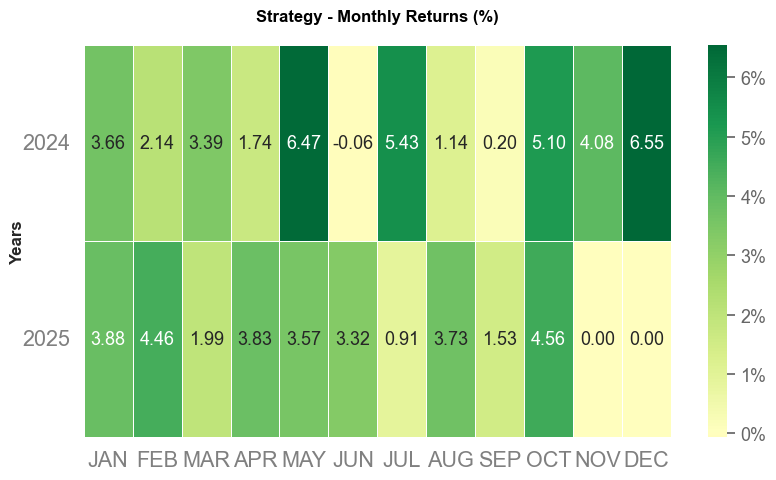

In [39]:
df_trades2.index = pd.to_datetime(df_trades2.index)
qs.plots.monthly_heatmap(df_trades2["return"])

                           Strategy
-------------------------  ----------
Start Period               2024-01-01
End Period                 2025-10-14
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          101.67%
CAGR﹪                     31.14%

Sharpe                     4.3
Prob. Sharpe Ratio         100.0%
Smart Sharpe               3.7
Sortino                    7.64
Smart Sortino              6.57
Sortino/√2                 5.4
Smart Sortino/√2           4.65
Omega                      2.09

Max Drawdown               -2.76%
Longest DD Days            35
Volatility (ann.)          9.73%
Calmar                     11.27
Skew                       0.26
Kurtosis                   1.63

Expected Daily %           0.16%
Expected Monthly %         3.24%
Expected Yearly %          42.01%
Kelly Criterion            34.03%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.84%
Expected Shortfall (cVaR)  -0.84%

Max Consecutive Wins       9

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2025-06-26,2025-07-10,2025-07-21,26,-2.762306,-2.545897
2,2025-01-10,2025-01-17,2025-01-30,21,-2.306538,-1.852243
3,2025-04-11,2025-04-16,2025-04-16,6,-2.124769,-1.259344
4,2024-06-12,2024-07-02,2024-07-16,35,-2.019476,-1.935400
5,2024-09-17,2024-09-20,2024-10-01,15,-1.951006,-1.819467


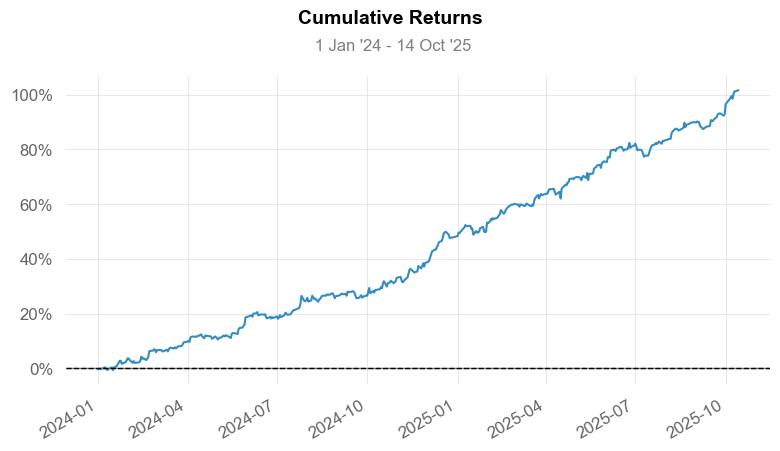

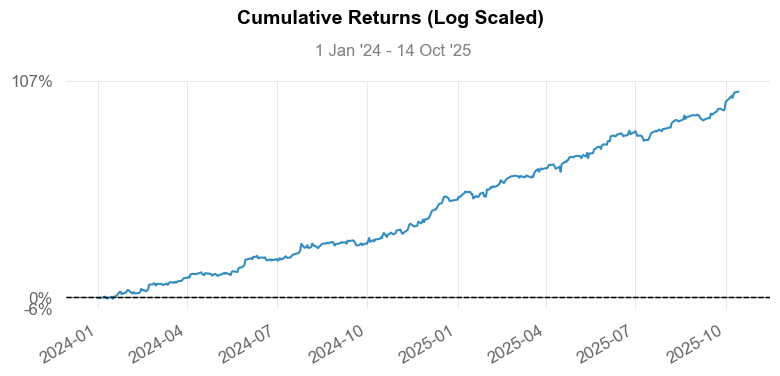

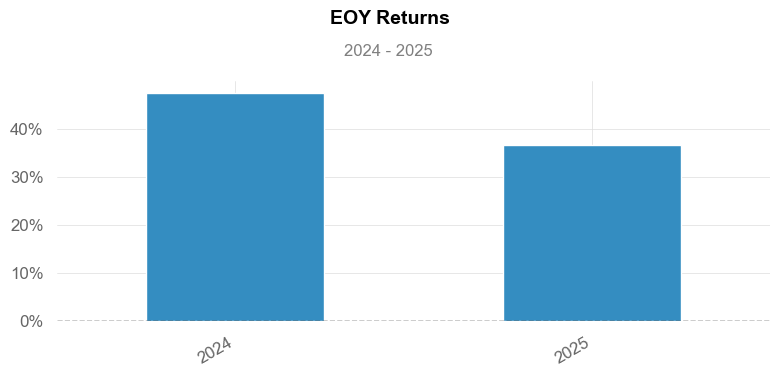

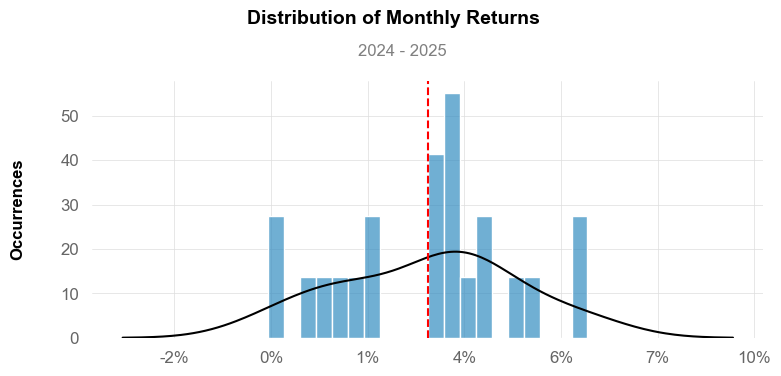

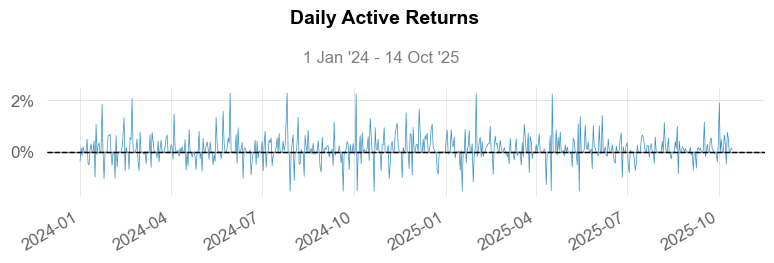

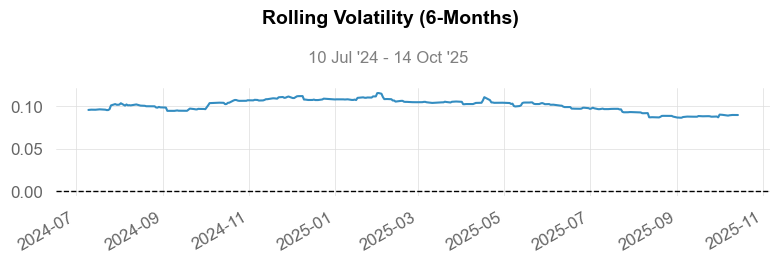

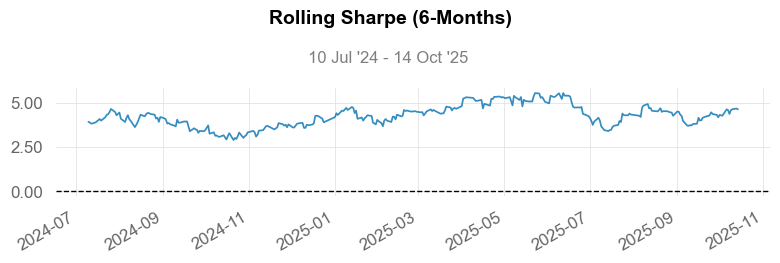

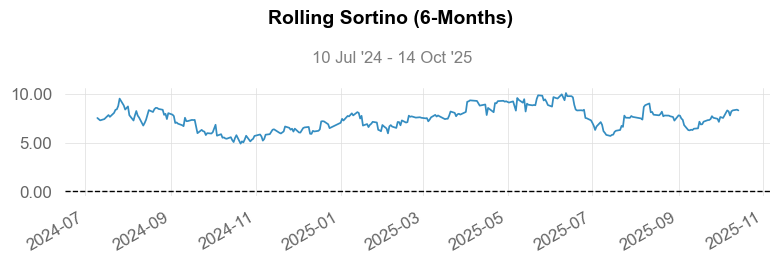

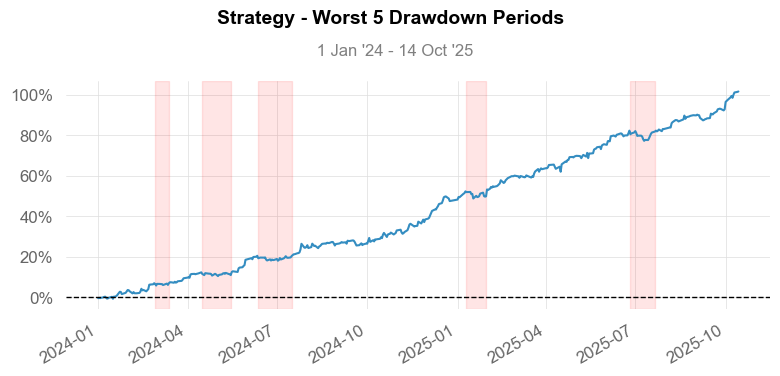

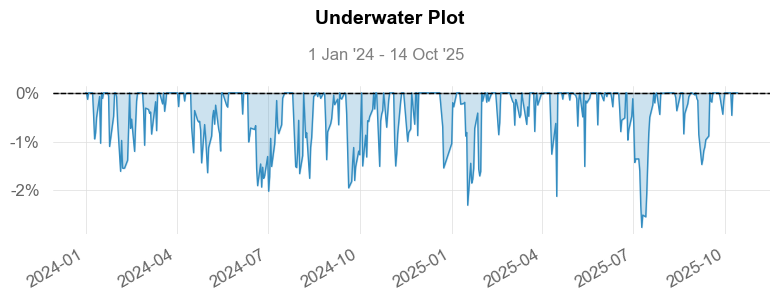

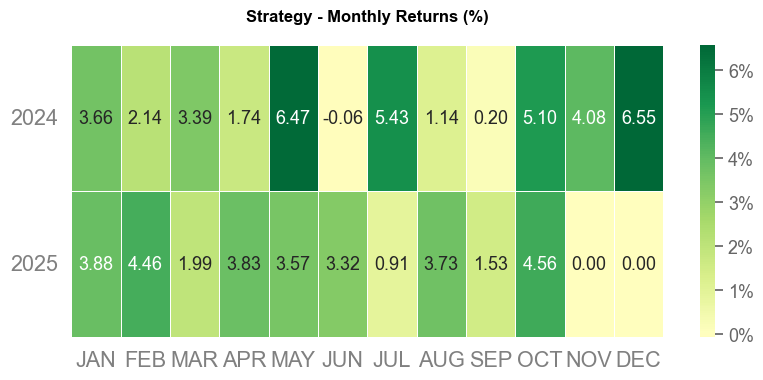

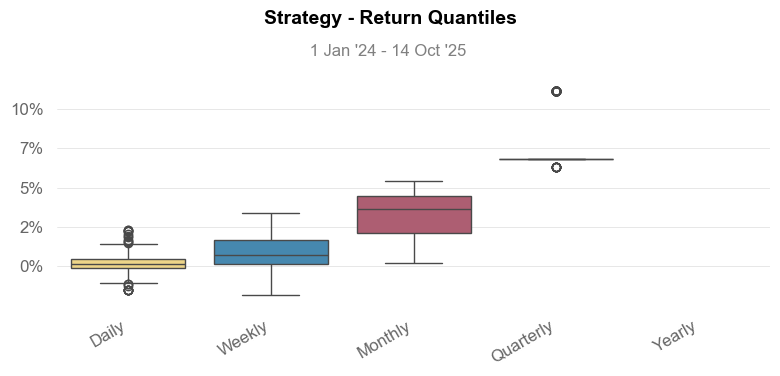

In [40]:
qs.reports.full(df_trades2["return"])

In [18]:
df_trades2.to_csv(r"D:\USER_DATA\Desktop\Trading setup\tradefile.csv")

In [19]:
df_trades.to_csv(r"D:\USER_DATA\Desktop\Trading setup\trades.csv")

In [129]:
qs.reports.html(df_trades2["return"] , output = "Sudhanshu_directional.html")

In [68]:
df_trades.to_csv(r"D:\USER_DATA\Desktop\NIfty csv\logic2.1_with 10mns logic and 3mins.csv")

In [69]:
df_trades2.to_csv(r"D:\USER_DATA\Desktop\NIfty csv\pnlsheet_logic_2.1.csv")